# M5 Forecasting Challenge

### Бизнес-проблема
Наличие нужных продуктов в нужном месте в нужное время было одним из самых сложных аспектов розничной торговли. Если у магазина слишком много запасов, часто его необходимо глубоко дисконтировать, чтобы продать его, что приводит к снижению прибыли или, возможно, к продаже этих товаров в убыток. И, если это скоропортящиеся товары, то с их утилизацией связаны дополнительные расходы. Покупка большего количества инвентарных запасов, чем необходимо, является плохим использованием оборотного капитала; однако, если в магазине недостаточно запасов, могут быть потеряны продажи, а также разочарование клиентов.

Текущие решения для данной проблемы часто включают использование электронных таблиц или классических статистических методов, таких как модели ARIMA. Эти решения ограничены агрегированными уровнями, такими как отделы или категории. Кроме того, эти методы не отражают нюансы в данных, такие как праздники, специальные события и продажи, приводящие к превышению запасов и нехватке запасов. Наша же модель позволяет учитывать больше событий, в связи с чем показывает результат лучше, чем модели ARIMA.

### Тезисы по нашей задаче:
- Нам поручено прогнозировать данные о продажах Wal-Mart
- Данные охватывают магазины в трех штатах США (Калифорния, Техас и Висконсин) и включают уровень товара, отдел, категории продуктов и информацию о магазинах.
- Кроме того, у него есть поясняющие переменные, такие как цена, акции, день недели и особые события.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import lightgbm as lgb
from matplotlib.pyplot import figure
from matplotlib import dates as mdates
from tqdm import tqdm
import datetime as dt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Data Files
- `calendar.csv` - Содержит информацию о датах продажи товаров.
- `sales_train_validation.csv` - Содержит исторические данные о продажах за день по продукту и магазину [d_1 - d_1913]
- `sample_submission.csv` - Правильный формат для сабмита
- `sell_prices.csv` - Содержит информацию о цене проданных товаров в каждом магазине и дате.
- `sales_train_evaluation.csv` - Включает продажи с [d_1 - d_1941] (labels used for the Public leaderboard)

In [4]:
# Читаем данные
cal = pd.read_csv('calendar.csv')
stv = pd.read_csv('sales_train_validation.csv')
ss = pd.read_csv('sample_submission.csv')
sellp = pd.read_csv('sell_prices.csv')

# Что мы должны предсказывать?
Мы попытаемся предсказывать продажи на следующие 28 дней. Конечный файл должен содержать следующее:
- Столбцы представляют 28 дней прогноза. Мы наполним эти прогнозные дни нашими прогнозами.
- Каждая строка представляет собой конкретный элемент. Этот идентификатор сообщает нам тип, состояние и хранилище элемента. Мы не знаем, что именно это за предметы.

In [5]:
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


У нас есть история продаж в  `sales_train_validation` датасете.
- строки в датасете состоят из дней d_1 to d_1913. Нам дается идентификатор отдела, категории, штата и магазина.
- d_1914 - d_1941 представляют `validation` строки, которые мы будем прогнозировать на этапе 1
- d_1942 - d_1969 представляют `evaluation` строки, которые мы спрогнозируем для окончательного зачета соревнований.

In [6]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


# Визуализация данных для одного товара
- Давайте возьмем случайный товар, который много продается, и посмотрим, как его продажи выглядят на основе данных обучения.
- `FOODS_3_090_CA_3_validation` продается достаточно много
- Обратите внимание, что есть дни, когда товар недоступен, а продажи фиксируются.

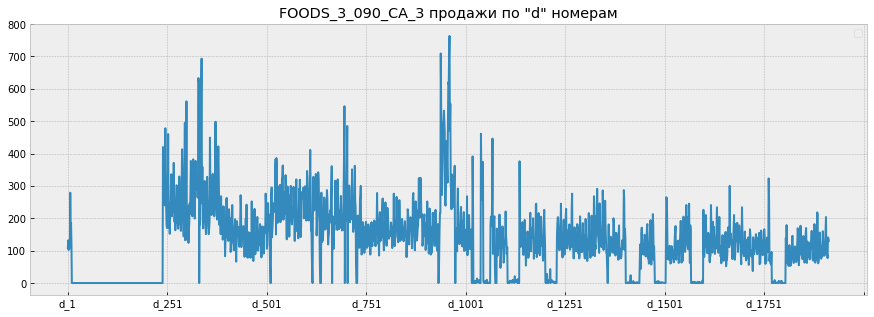

In [7]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Ниже мы объединяем следующие шаги в pandas:
# 1. Выбираем товар
# 2. Установите идентификатор в качестве индекса, оставьте только столбцы данных о продажах
# 3. Преобразуйте так, чтобы получился столбец
# 4. Отобразите данные
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 продажи по "d" номерам',
          color=next(color_cycle))
plt.legend('')
plt.show()

## Объединим данные с реальными датами
- Нам дается календарь с дополнительной информацией о прошедших и будущих датах.
- Данные календаря могут быть объединены с данными наших дней
- Отсюда мы можем найти еженедельные и годовые тенденции

In [8]:
# cal[cal['event_name_2'] != np.NaN]
cal[['event_name_1','event_name_2','event_type_1','event_type_2']] = cal[['event_name_1','event_name_2',
     'event_type_1','event_type_2']].astype(str)

In [9]:
cal[cal['event_name_1'] != 'nan'].head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,nan,nan,1,1,1
16,2011-02-14,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,nan,nan,0,0,1
23,2011-02-21,11104,Monday,3,2,2011,d_24,PresidentsDay,National,nan,nan,0,0,0
39,2011-03-09,11106,Wednesday,5,3,2011,d_40,LentStart,Religious,nan,nan,1,1,1
46,2011-03-16,11107,Wednesday,5,3,2011,d_47,LentWeek2,Religious,nan,nan,0,0,0


### Пояснение к данным:
- `wm_yr_wk` - номер недели
- `weekday` - день недели
- `wday` - порядковый номер дня недели
- `month` - номер месяца
- `year` - год
- `d` - дни продаж
- `date` - конкретная дата продаж
- `event_name_1` и `event_name_2` - название мероприятия/праздника в этот день
- `event_type_1` и `event_type_2` - типы мероприятия №1 и №2 соответственно (Например, культурный праздник, спортивный и тд)
- `span_CA`, `span_TX`, `span_WI` - наличие скидки в конкретном магазине штата (CA - California, TX - Texas, WI - Wisconsin

### Отобразим график с нормальными датами

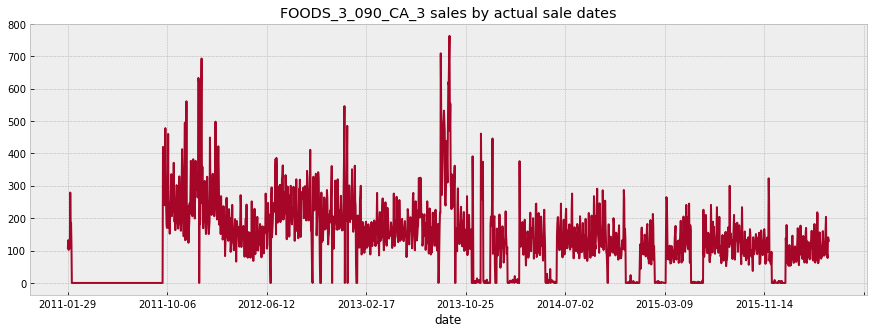

In [10]:
# Объединить календарь с данными о наших товарах
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Назовем их корректно
example = example.reset_index().rename(columns={'index': 'd'}) # добавим "d" индекс
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

# Выберите больше самых продаваемых примеров
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Назовем их корректно
example2 = example2.reset_index().rename(columns={'index': 'd'}) # добавим "d" индекс
example2 = example2.merge(cal, how='left', validate='1:1')

example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Назовем их корректно
example3 = example3.reset_index().rename(columns={'index': 'd'}) # добавим "d" индекс
example3 = example3.merge(cal, how='left', validate='1:1')

#### Получаем график с удобными для восприятия датами 

# Продажи с разбивкой по временным переменным
- Теперь, когда у нас есть наш пример товара, давайте посмотрим, как он продается:
    - День недели
    - Месяц
    - Год

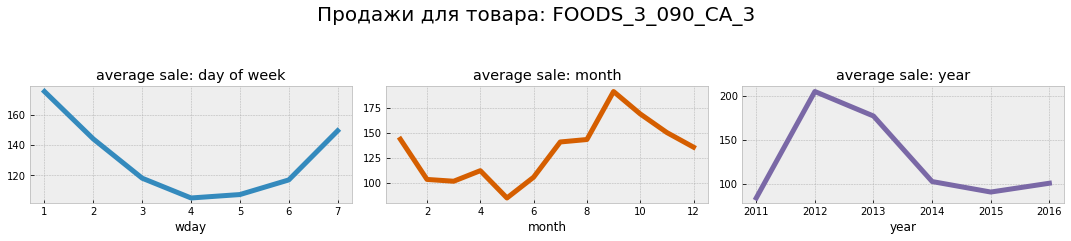

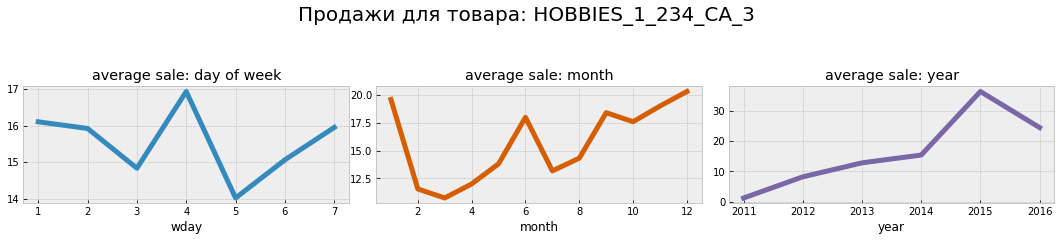

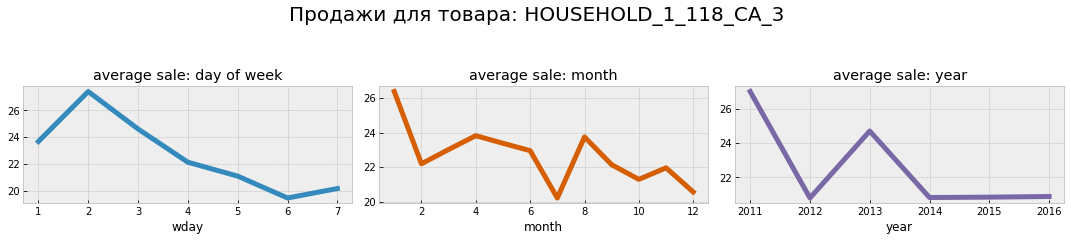

In [11]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Продажи для товара: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

# Посмотрим на большее кол-во товаров
Давайте соберем все вместе, чтобы построить 20 различных предметов и их продажи.

In [12]:
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

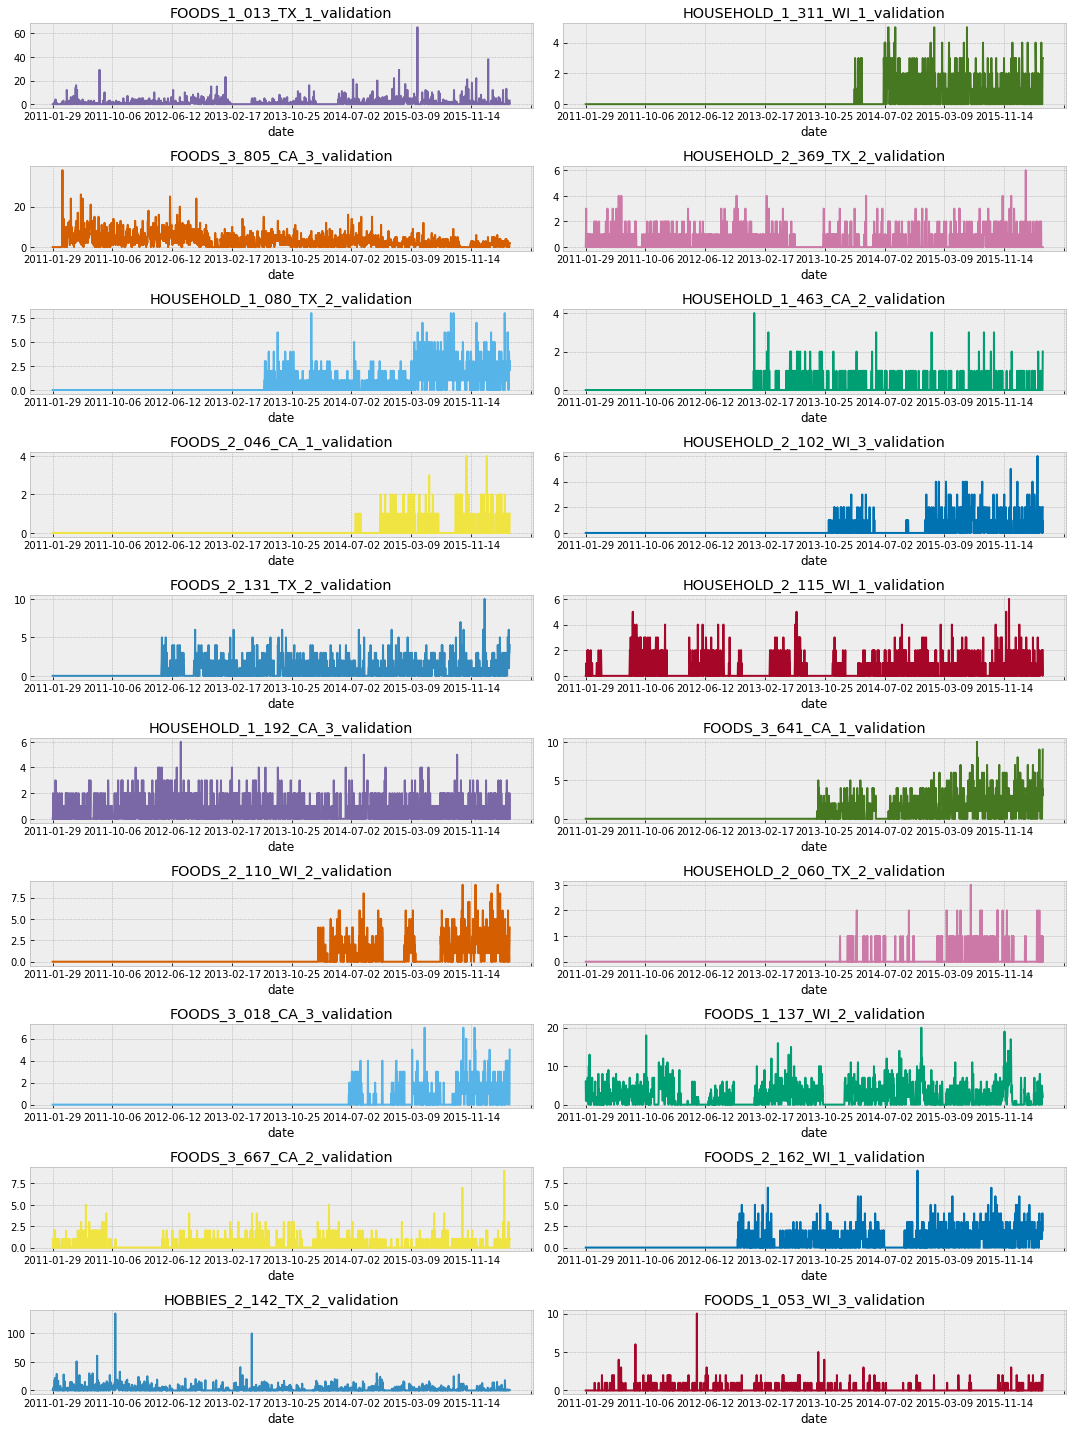

In [13]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

### Некоторые наблюдения с графиков:
- Обычно товар недоступен в течение определенного периода времени.
- Некоторые предметы продаются только 1 или меньше в день, поэтому их очень сложно предсказать.
- На другие товары наблюдается всплеск их спроса. Кажется, что предоставленные нам "мероприятия" могут помочь с этим.

# Комбинированные продажи с течением времени по типу
- У нас есть несколько типов товаров:
    - Hobbies
    - Household
    - Foods
- Построим график общего спроса с течением времени для каждого типа

In [14]:
stv['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

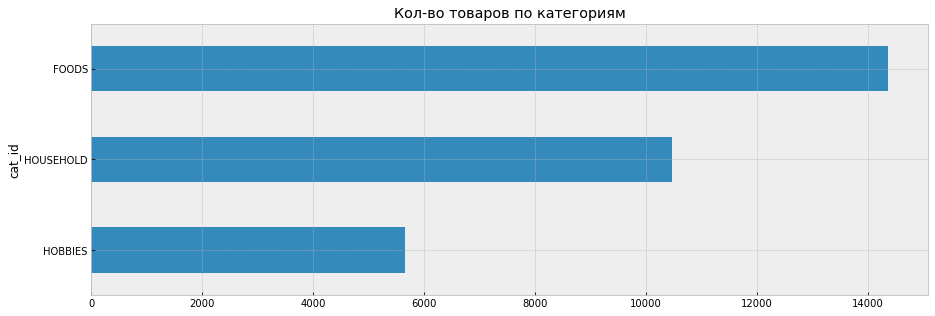

In [15]:
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Кол-во товаров по категориям')
plt.show()

### Некоторые выводы к графику
- Имеется разное кол-во товаров данных категорий
- Товаров категории больше всего - чуть больше 140000

## Построим график итоговых продаж
Нам хочется понять как ведут себя продажи товаров по его типу и по годам

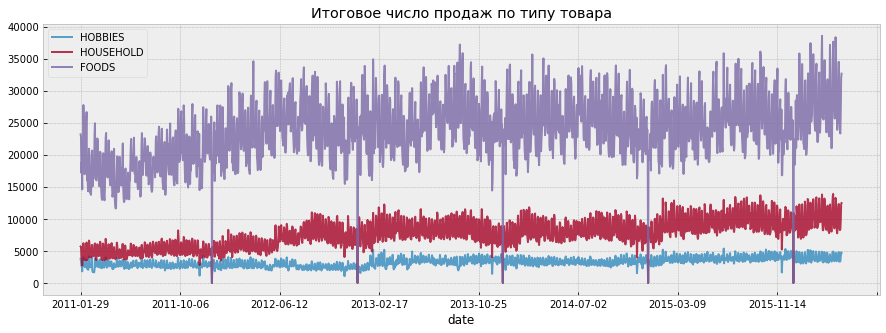

In [16]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Итоговое число продаж по типу товара')
plt.legend(stv['cat_id'].unique())
plt.show()

### Некоторые наблюдения к графику
- Можно увидеть, что в поставку поступают некоторые предметы, которых раньше не было. Аналогичным образом некоторые предметы перестают продаваться полностью.
- Построим график продаж, но посчитаем только если товар продается или не продается (0 -> не продается, >0 -> продается)
- Этот график показывает нам, что многие предметы медленно вводятся в инвентарь, поэтому многие из них не регистрируют продажу в начале предоставленных данных.

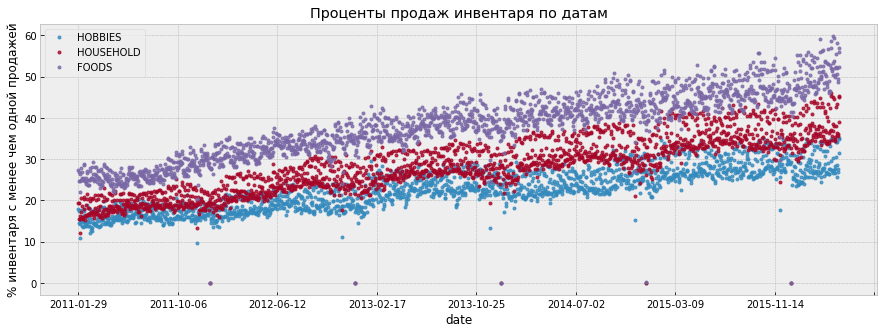

In [17]:
past_sales_clipped = past_sales.clip(0, 1)
for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    (past_sales_clipped[items_col] \
        .mean(axis=1) * 100) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Проценты продаж инвентаря по датам',
              style='.')
plt.ylabel('% инвентаря с менее чем одной продажей')
plt.legend(stv['cat_id'].unique())
plt.show()

# Продажи по магазинам
Приведены данные по 10 уникальным магазинам. Каковы общие продажи по магазинам?

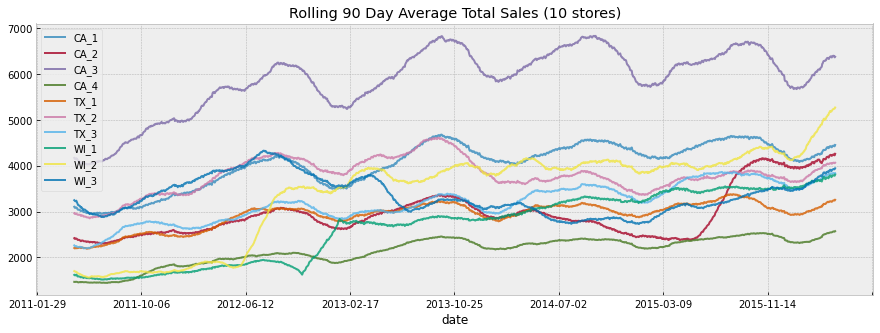

In [18]:
store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

Выводы к графику:
- Обратите внимание, что одни магазины более стабильны, чем другие.
- Кажется что CA_2 продажи после 2015 пойдут вверх

### Взглянув на те же данные с другой стороны, мы можем построить скользящий 7-дневный общий объем спроса по магазинам.

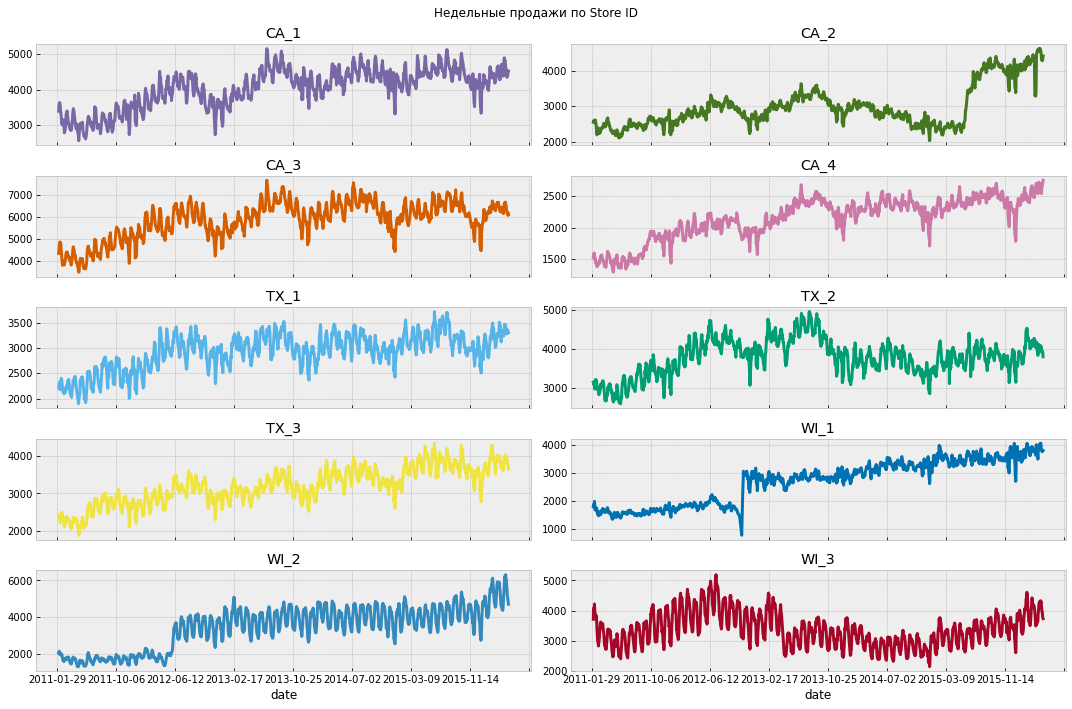

In [19]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Недельные продажи по Store ID')
plt.tight_layout()
plt.show()

### Некоторые выводы к графикам
- Обратите внимание на то, что в некоторых магазинах резко меняется спрос: возможно, магазин расширился или поблизости появился новый конкурент. В любом случае это важно учитывать при создании прогнозных моделей структуры спроса.

# Heatmap Calendar продаж
Heatmap Calendar продаж поможет нам посмотреть как у нас идут ежедневные продажи в месяц по годам. Рассмотрим на примере наших 3-х категорий.

In [20]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

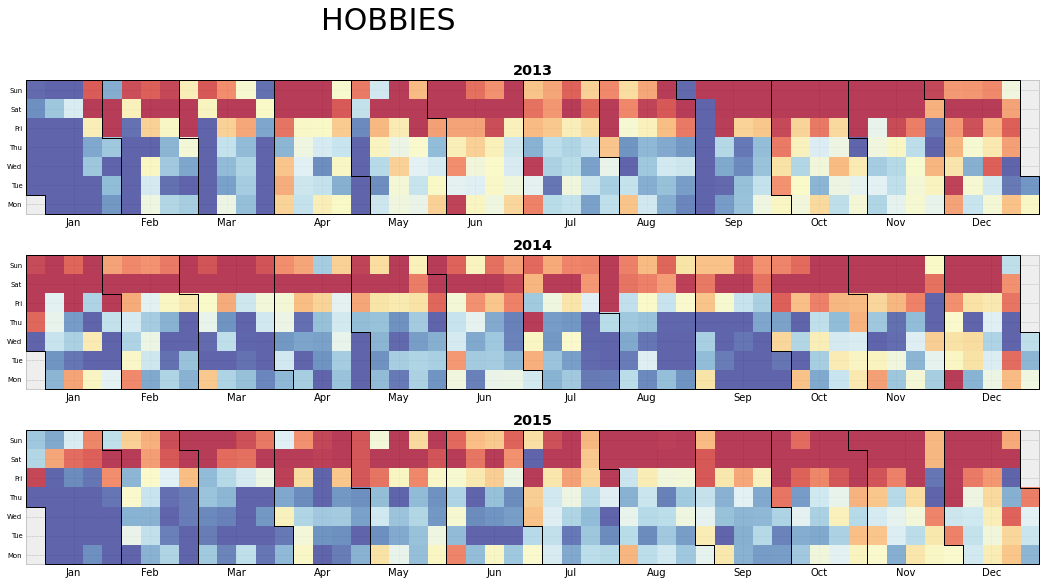

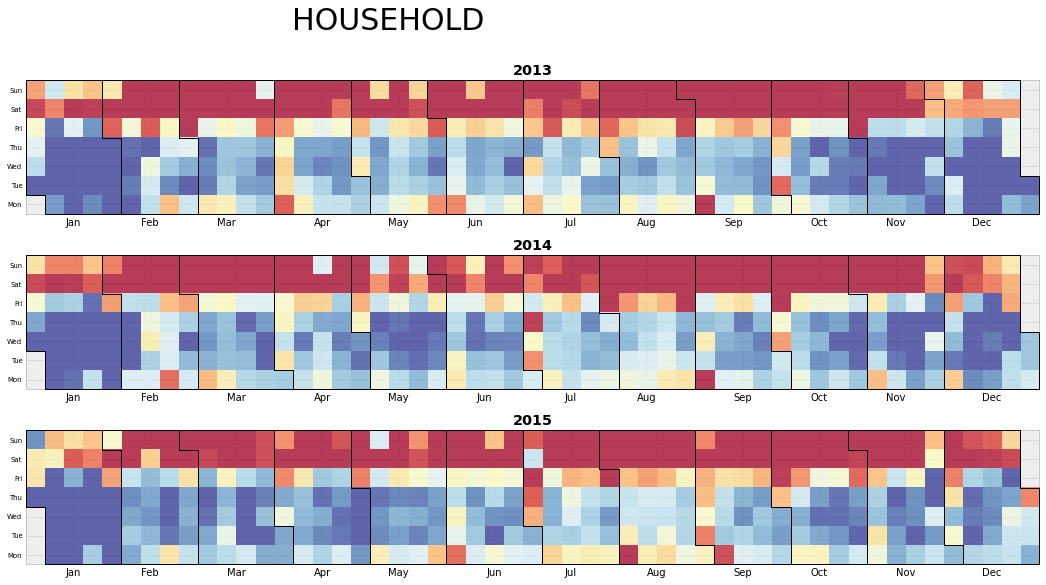

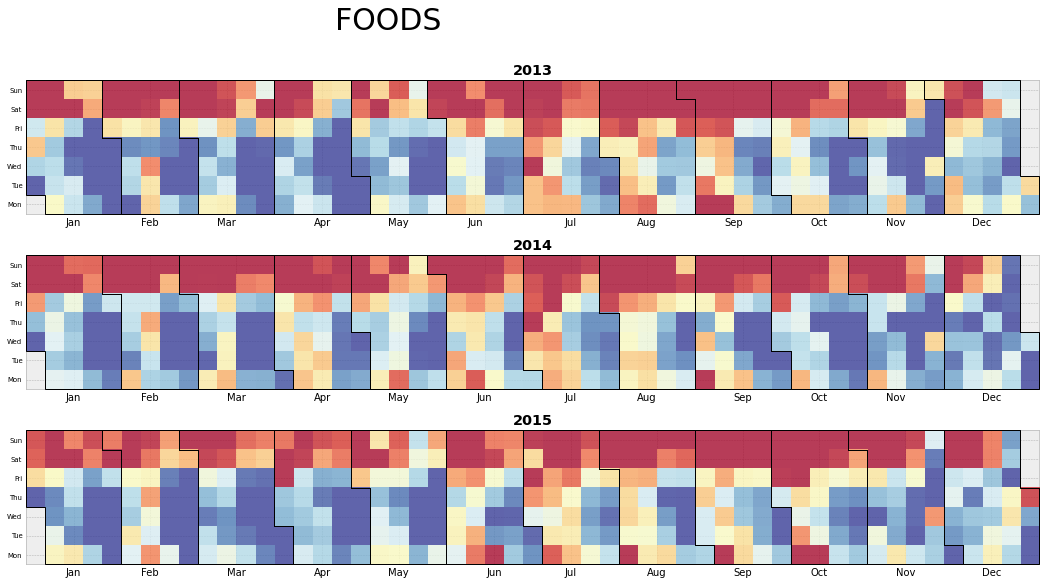

In [21]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in stv['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

### Некоторые вывод по этим heapmap'ам:
- В течение месяца количество покупок продуктов питания, как правило, уменьшается. Может быть, это потому, что люди получают зарплату в начале месяца?
- Household and Hobby товары продаются намного меньше в январе - после окончания курортного сезона.

### Посмотрим на максимальное и минимальное число продаж

In [22]:
print('Дата с наименьшим числом продаж:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('Дата с наибольшим числом продаж:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')

Дата с наименьшим числом продаж: 2012-12-25 00:00:00 with 11 sales
Дата с наибольшим числом продаж: 2016-03-06 00:00:00 with 57218 sales


Похоже, что в день Рождества волмарты закрыты. Самый высокий спрос среди всех данных пришелся на воскресенье, 6 марта 2016 года. Что произошло в этот день?[седьмые дебаты кандидатов в президенты от Демократической партии, организованные CNN во Флинте, штат Мичиган] (https: // www.onthisday.com/date/2016/march/6)

# Цены продажи
Нам даны исторические цены продажи каждой позиции. Давайте посмотрим на наш примере товара `FOODS_3_090`

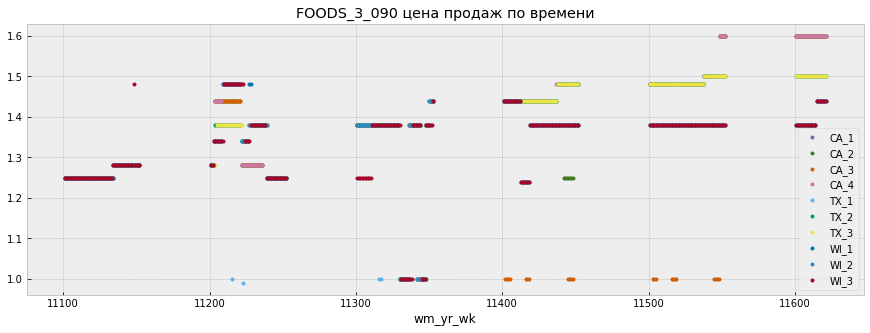

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in sellp.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          figsize=(15, 5),
          title='FOODS_3_090 цена продаж по времени',
         ax=ax,
          legend=store)
    stores.append(store)
    plt.legend()
plt.legend(stores)
plt.show()

### Некоторые выводы к графику
- Кажется, что цена на товар FOODS_3_090 растет.
- В разных магазинах разные цены.

## Графики распределений

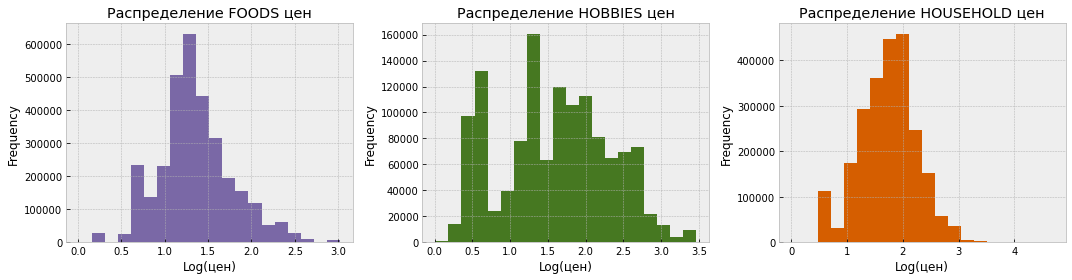

In [24]:
sellp['Category'] = sellp['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for cat, d in sellp.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
                         bins=20,
                         title=f'Распределение {cat} цен',
                         ax=axs[i],
                                         color=next(color_cycle))
    ax.set_xlabel('Log(цен)')
    i += 1
plt.tight_layout()

### Выводы по графикам
Посмотрев на графики выше, мы можем сделать несколько выводов:
- Распределения похожи на нормальные
- Кажется, что на график распределения товаров категории HOBBIES влияют праздники, либо скидки с постоянной ценой, при их наличии

# Начало решения

Ранее мы проводили анализ имеющихся данных, выпишем основные тезисы, которые стоит учесть в модели:
##### Ключевые данные
- Данные праздников, акций и скидок имеют значение
- Данные продаж по дням, по категориям, по магазинам

##### Стоит обратить внимание, что
- Бывают резкие перепады кол-ва продаж
- Одни магазины более стабильны, чем другие

На базе данных тезисов мы будем строить наше решение

## Читаем данные

In [25]:
sell_prices = pd.read_csv('sell_prices.csv')
sample_submission = pd.read_csv('sample_submission.csv')
calendar = pd.read_csv('calendar.csv')
sales_train_validation = pd.read_csv('sales_train_evaluation.csv')

## Работаем с данными

### Приводим их в нужный нам вид

In [26]:
sales_data = pd.DataFrame(sales_train_validation).reset_index()
for i in range(1942, 1972):
    sales_data['d_' + str(i)] = 0

sell_prices = pd.read_csv('sell_prices.csv')
sell_prices['id'] = sell_prices['item_id'] + '_' + sell_prices['store_id']
sell_prices = sell_prices.pivot(index='id', columns = 'wm_yr_wk', values = 'sell_price').reset_index()
sell_prices = sell_prices.fillna(method='bfill', axis=1)
test = sales_data['item_id'] + '_' + sales_data['store_id']
sell_prices = sell_prices.set_index('id')
sell_prices = sell_prices.reindex(test)
sell_prices = sell_prices.reset_index()

### Обробатываем данные праздников и скидок

Ранее мы пришли к выводу, что данные праздников и скидок имеют зачение в успешности предсказаний. Давайте учитывать их в нашей модели. В `event_name_1` и `event_name_2` находятся названия праздников. Так как модель не умеет работать с текстами, мы представим их в качестве цифр (поочередно пронумеруем каждый праздник от 1 до n, где n - кол-во праздников). 
В таком виде мы уже сможем использовать их при обучении

In [27]:
labels = calendar[['d', 'event_name_1', 'event_name_2', 'snap_CA', 'snap_TX', 'snap_WI', 'wday', 'month', 'year', 'wm_yr_wk']].reset_index()
labels = labels.fillna(0)
#labels['wm_yr_wk'] = int(labels['wm_yr_wk'])
labels['event_name_1'] = labels['event_name_1'].astype('str')
labels['event_name_2'] = labels['event_name_2'].astype('str')

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
label_encoder = label_encoder.fit(labels['event_name_1'])
label_encoded_event1 = label_encoder.transform(labels['event_name_1'])
label_encoder = label_encoder.fit(labels['event_name_2'])
label_encoded_event2 = label_encoder.transform(labels['event_name_2'])
labels['event_name_1_encode'] = label_encoded_event1
labels['event_name_2_encode'] = label_encoded_event2

### Смотрим на результаты преобразований

In [28]:
labels[labels['event_name_1'] != '0'].head()

,index,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,wday,month,year,wm_yr_wk,event_name_1_encode,event_name_2_encode
8,8,d_9,SuperBowl,0,1,1,1,2,2,2011,11102,27,0
16,16,d_17,ValentinesDay,0,0,0,1,3,2,2011,11103,29,0
23,23,d_24,PresidentsDay,0,0,0,0,3,2,2011,11104,23,0
39,39,d_40,LentStart,0,1,1,1,5,3,2011,11106,12,0
46,46,d_47,LentWeek2,0,0,0,0,5,3,2011,11107,13,0


В новой таблице мы получили новые колонки `event_name_1_encode` и `event_name_2_encode` в которых как раз указаны порядковые номера праздников. 

# Настраиваем параметры модели

In [29]:
#lgbm Model
params = {

#         'boosting_type': 'gbdt',
        'force_col_wise':True,
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 20,
        'learning_rate': 0.4,
        'alpha': 0.2,
        'lambda': 0.1,
        'bagging_fraction': 0.56,
        'bagging_freq': 20, 
        'colsample_bytree': 0.77,
        'verbosity': -1
}

In [30]:
count_valid_days = 41

In [31]:
ss[[f'F{x}' for x in range(29,count_valid_days+29)]] = 0.

# Начинаем обучение

### Как это работает?
В данной задаче мы подсчитываем стандартные отколнения, средние значения и вносим их в наши признаки.
Признаки состоят из наших праздников, скидок, которые мы ранее преобразовали, а также имеющихся цен товаров.
После того как мы все посчитали, мы прогоняем все через модель и получаем новые(предсказанные) значения!!😎😎😎

In [32]:
#hide-input
for i in tqdm(range(0, len(sales_data))): # Проходим по всем имеющимся данным (которые мы ранее преобразовали)
    temp = pd.DataFrame(sales_data.loc[i][7:]).reset_index()
    temp = temp.rename(columns = {"index": "d", i: "sales"})
    sales_all = labels.merge(temp, on=["d"])
    sales_all = sales_all.merge(sell_prices.reset_index().loc[i], on=['wm_yr_wk'])
    
    # Здесь мы считаем средние и стандартные отклонения
    sales_all['lag_28'] = sales_all['sales'].shift(28)

    sales_all['rolling_std_t7'] = sales_all[i].transform(lambda x: x.rolling(7).std())
    sales_all['rolling_std_t30'] = sales_all[i].transform(lambda x: x.rolling(30).std())
    
    sales_all['rolling_mean_7'] = sales_all['sales'].transform(lambda x: x.shift(28).rolling(7).mean())
    sales_all['rolling_mean_30'] = sales_all['sales'].transform(lambda x: x.shift(28).rolling(30).mean())
    sales_all['rolling_mean_60'] = sales_all['sales'].transform(lambda x: x.shift(28).rolling(60).mean())
    
    sales_all['lag_price_t1'] = sales_all[i].transform(lambda x: x.shift(1))   
    sales_all['price_change_t1'] = (sales_all['lag_price_t1'] - sales_all[i]) / sales_all['lag_price_t1']
    
    sales_all.drop(['lag_price_t1'], inplace = True, axis = 1)
    
    # Соединяем посчитанные признаки с исходными
    features = ['event_name_1_encode', 'event_name_2_encode', 'snap_' + sales_data['state_id'][i]
                , 'wday','month', 'year'
                , 'lag_28'
                , 'rolling_std_t7', 'rolling_std_t30'
                , 'rolling_mean_7', 'rolling_mean_30', 'rolling_mean_60'
                , 'price_change_t1', i]
    features_sales = ['event_name_1_encode', 'event_name_2_encode', 'snap_' + sales_data['state_id'][i]
                , 'wday','month', 'year'
                , 'lag_28'
                , 'rolling_std_t7', 'rolling_std_t30'
                , 'rolling_mean_7', 'rolling_mean_30', 'rolling_mean_60'
                , 'price_change_t1',i, 'sales']
    
    sales_all[features_sales] = sales_all[features_sales].applymap(float)

    # А здесь происходит магия...
    X_train = lgb.Dataset(sales_all[features][0:1940]
                      , label = sales_all[['sales']][0:1940])
    clf = lgb.train(params, X_train)
    y_pred = clf.predict(sales_all[features][1941-count_valid_days:])
   
    ss.iloc[i+30490, 1:] = y_pred
    if i == 100:
        break

  0%|▏                                                                           | 100/30490 [00:48<4:04:30,  2.07it/s]


### Формируем csv файл с нашими предсказаниями

In [33]:
ss.to_csv("submission.csv", index=False)

# Анализ файла предсказаний

In [34]:
sub = pd.read_csv("submission.csv")

In [35]:
columns = sub.id
sub.drop(['id'],inplace=True,axis=1)
sub = sub.T
sub['date'] = [dt.date(2016,4,25)+dt.timedelta(days=x)-dt.timedelta(days=count_valid_days) for x in range(len(sub))]
sub = sub.set_index('date')
sub.columns = columns.values

## Анализ полученных результатов

Наша модель отработала, мы получили результаты. Появляется вопрос: "А как нам понять, что результаты верны?"
Для этого мы используем метрику **Weighted Root Mean Squared Scaled Error** (RMSSE)
<img src="rmse.jpg"/>

Данная метрика показывает ...

# Графики некоторых предсказаний

На данных графиках мы можем видеть, красной линией - то что предсказала наша модель, а синей - то что было в данных

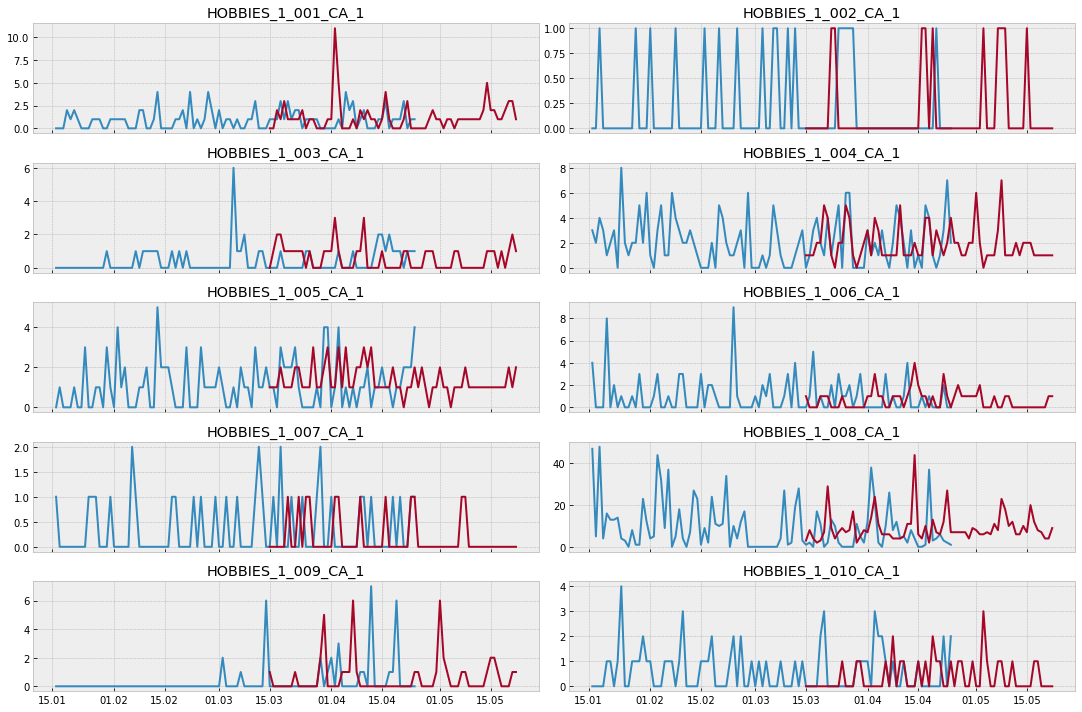

In [36]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()

ax_idx = 0
for s in past_sales.columns[0:]:
    item = "_".join(s.split('_')[:-1])
    axes[ax_idx].set_title(item)
    axes[ax_idx].xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    axes[ax_idx].plot(past_sales.index[-100:],past_sales[f"{item}_validation"][-100:],sub.index,sub[f"{item}_evaluation"].round())
    ax_idx += 1
    if ax_idx == 10:
        break
plt.tight_layout()
plt.show()

In [55]:
counter = 0
error = 0
from sklearn.metrics import mean_squared_error
for i in past_sales.columns[:100]:
    item = "_".join(i.split("_")[:-1])
    vals = f'{item}_validation'
    evals = f'{item}_evaluation'
    v = past_sales[vals][-41:]
    e = sub[evals][:-28]
    counter += sum((e-v)**2)
    error += sum(abs(v-e))
print(f'Среднеквадратичная ошибка для нашей модели: {(counter/2800)**.5}')
print(f'В среднем модель ошибается на {error/2800} товаров(предеметов? как лучше написать?) за день для каждого наименования товаров')


Среднеквадратичная ошибка для нашей модели: 3.508734161994632
В среднем модель ошибается на 1.8127046229378123 товаров(предеметов? как лучше написать?) за день для каждого наименования товаров
